In [1]:
!git clone -b leo-1 --single-branch https://github.com/leopomme/NLP-Sentiment-Analysis

Cloning into 'NLP-Sentiment-Analysis'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 26 (delta 4), reused 19 (delta 3), pack-reused 0
Receiving objects: 100% (26/26), 83.37 KiB | 2.98 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:
from typing import List

import torch
import itertools
from typing import Dict, List, Optional
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.preprocessing import LabelEncoder
import torch.optim as optim
from sklearn.metrics import accuracy_score
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')  # other pre-trained models like 'roberta-base'

In [3]:
import os
os.chdir('/kaggle/working/NLP-Sentiment-Analysis/src/')


In [5]:
import time, sys
import numpy as np
import argparse

import torch

from classifier import Classifier


def set_reproducible():
    # The below is necessary to have reproducible behavior.
    import random as rn
    import os
    os.environ['PYTHONHASHSEED'] = '0'
    # The below is necessary for starting Numpy generated random numbers
    # in a well-defined initial state.
    np.random.seed(17)
    # The below is necessary for starting core Python generated random numbers
    # in a well-defined state.
    rn.seed(12345)



def load_label_output(filename):
    with open(filename, 'r', encoding='UTF-8') as f:
        return [line.strip().split("\t")[0] for line in f if line.strip()]



def eval_list(glabels, slabels):
    if (len(glabels) != len(slabels)):
        print("\nWARNING: label count in system output (%d) is different from gold label count (%d)\n" % (
        len(slabels), len(glabels)))
    n = min(len(slabels), len(glabels))
    incorrect_count = 0
    for i in range(n):
        if slabels[i] != glabels[i]: incorrect_count += 1
    acc = (n - incorrect_count) / n
    return acc*100



def train_and_eval(classifier, trainfile, devfile, testfile, run_id, device):
    print(f"\nRUN: {run_id}")
    print("  %s.1. Training the classifier..." % str(run_id))
    classifier.train(trainfile, devfile, device)
    print()
    print("  %s.2. Eval on the dev set..." % str(run_id), end="")
    slabels = classifier.predict(devfile, device)
    glabels = load_label_output(devfile)
    devacc = eval_list(glabels, slabels)
    print(" Acc.: %.2f" % devacc)
    testacc = -1
    if testfile is not None:
        # Evaluation on the test data
        print("  %s.3. Eval on the test set..." % str(run_id), end="")
        slabels = classifier.predict(testfile)
        glabels = load_label_output(testfile)
        testacc = eval_list(glabels, slabels)
        print(" Acc.: %.2f" % testacc)
    print()
    return (devacc, testacc)


if __name__ == "__main__":
    device_name = "cuda"
    device = torch.device(device_name)
    n_runs = 10
    set_reproducible()
    datadir = "../data/"
    trainfile =  datadir + "traindata.csv"
    devfile =  datadir + "devdata.csv"
    testfile = None
    # testfile = datadir + "testdata.csv"

    # Runs
    start_time = time.perf_counter()
    devaccs = []
    testaccs = []
    for i in range(1, n_runs+1):
        classifier =  Classifier()
        devacc, testacc = train_and_eval(classifier, trainfile, devfile, testfile, i, device)
        devaccs.append(np.round(devacc,2))
        testaccs.append(np.round(testacc,2))
    print('\nCompleted %d runs.' % n_runs)
    total_exec_time = (time.perf_counter() - start_time)
    print("Dev accs:", devaccs)
    print("Test accs:", testaccs)
    print()
    print("Mean Dev Acc.: %.2f (%.2f)" % (np.mean(devaccs), np.std(devaccs)))
    print("Mean Test Acc.: %.2f (%.2f)" % (np.mean(testaccs), np.std(testaccs)))
    print("\nExec time: %.2f s. ( %d per run )" % (total_exec_time, total_exec_time / n_runs))


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


RUN: 1
  1.1. Training the classifier...


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 1,Loss: 0.6997, Dev Accuracy: 0.8351


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 2,Loss: 0.4142, Dev Accuracy: 0.8298


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 3,Loss: 0.3102, Dev Accuracy: 0.8378


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 4,Loss: 0.2511, Dev Accuracy: 0.8351


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 5,Loss: 0.2099, Dev Accuracy: 0.8324


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 6,Loss: 0.1813, Dev Accuracy: 0.8165


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 7,Loss: 0.1572, Dev Accuracy: 0.8245


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 8,Loss: 0.1325, Dev Accuracy: 0.8059


100%|██████████| 94/94 [00:14<00:00,  6.52it/s]


Epoch: 9,Loss: 0.1330, Dev Accuracy: 0.8085


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 10,Loss: 0.1144, Dev Accuracy: 0.7979

  1.2. Eval on the dev set... Acc.: 79.79



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


RUN: 2
  2.1. Training the classifier...


100%|██████████| 94/94 [00:14<00:00,  6.52it/s]


Epoch: 1,Loss: 0.6413, Dev Accuracy: 0.8351


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 2,Loss: 0.3991, Dev Accuracy: 0.8378


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 3,Loss: 0.3242, Dev Accuracy: 0.8298


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 4,Loss: 0.2747, Dev Accuracy: 0.8378


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 5,Loss: 0.2354, Dev Accuracy: 0.8431


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 6,Loss: 0.2003, Dev Accuracy: 0.8431


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 7,Loss: 0.1801, Dev Accuracy: 0.8351


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 8,Loss: 0.1588, Dev Accuracy: 0.8271


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 9,Loss: 0.1433, Dev Accuracy: 0.8245


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 10,Loss: 0.1214, Dev Accuracy: 0.8165

  2.2. Eval on the dev set... Acc.: 81.65



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


RUN: 3
  3.1. Training the classifier...


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 1,Loss: 0.6640, Dev Accuracy: 0.8298


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 2,Loss: 0.3883, Dev Accuracy: 0.8457


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 3,Loss: 0.3018, Dev Accuracy: 0.8032


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 4,Loss: 0.2488, Dev Accuracy: 0.8298


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 5,Loss: 0.2029, Dev Accuracy: 0.8511


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 6,Loss: 0.1751, Dev Accuracy: 0.8457


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 7,Loss: 0.1527, Dev Accuracy: 0.8351


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 8,Loss: 0.1338, Dev Accuracy: 0.8404


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 9,Loss: 0.1242, Dev Accuracy: 0.8245


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 10,Loss: 0.1115, Dev Accuracy: 0.8298

  3.2. Eval on the dev set... Acc.: 82.98



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


RUN: 4
  4.1. Training the classifier...


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 1,Loss: 0.6295, Dev Accuracy: 0.8404


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 2,Loss: 0.3899, Dev Accuracy: 0.8191


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 3,Loss: 0.3338, Dev Accuracy: 0.8191


100%|██████████| 94/94 [00:14<00:00,  6.48it/s]


Epoch: 4,Loss: 0.2750, Dev Accuracy: 0.8324


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 5,Loss: 0.2446, Dev Accuracy: 0.8484


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 6,Loss: 0.2244, Dev Accuracy: 0.8378


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 7,Loss: 0.2079, Dev Accuracy: 0.8378


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 8,Loss: 0.1841, Dev Accuracy: 0.8351


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 9,Loss: 0.1808, Dev Accuracy: 0.8298


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 10,Loss: 0.1571, Dev Accuracy: 0.8378

  4.2. Eval on the dev set... Acc.: 83.78



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


RUN: 5
  5.1. Training the classifier...


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 1,Loss: 0.7200, Dev Accuracy: 0.8378


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 2,Loss: 0.4051, Dev Accuracy: 0.8032


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 3,Loss: 0.3105, Dev Accuracy: 0.8165


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 4,Loss: 0.2732, Dev Accuracy: 0.8324


100%|██████████| 94/94 [00:14<00:00,  6.51it/s]


Epoch: 5,Loss: 0.2225, Dev Accuracy: 0.8431


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 6,Loss: 0.2024, Dev Accuracy: 0.8457


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 7,Loss: 0.1705, Dev Accuracy: 0.8271


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 8,Loss: 0.1545, Dev Accuracy: 0.8298


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 9,Loss: 0.1374, Dev Accuracy: 0.8271


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 10,Loss: 0.1294, Dev Accuracy: 0.8112

  5.2. Eval on the dev set... Acc.: 81.12



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


RUN: 6
  6.1. Training the classifier...


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 1,Loss: 0.6918, Dev Accuracy: 0.8032


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 2,Loss: 0.4084, Dev Accuracy: 0.8271


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 3,Loss: 0.3229, Dev Accuracy: 0.8165


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 4,Loss: 0.2630, Dev Accuracy: 0.8245


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 5,Loss: 0.2351, Dev Accuracy: 0.8271


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 6,Loss: 0.2105, Dev Accuracy: 0.8378


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 7,Loss: 0.1894, Dev Accuracy: 0.8404


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 8,Loss: 0.1667, Dev Accuracy: 0.8271


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 9,Loss: 0.1430, Dev Accuracy: 0.8298


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 10,Loss: 0.1391, Dev Accuracy: 0.8218

  6.2. Eval on the dev set... Acc.: 82.18



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


RUN: 7
  7.1. Training the classifier...


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 1,Loss: 0.7031, Dev Accuracy: 0.8351


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 2,Loss: 0.3933, Dev Accuracy: 0.8271


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 3,Loss: 0.3064, Dev Accuracy: 0.8404


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 4,Loss: 0.2506, Dev Accuracy: 0.8324


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 5,Loss: 0.2047, Dev Accuracy: 0.8351


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 6,Loss: 0.1685, Dev Accuracy: 0.8324


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 7,Loss: 0.1417, Dev Accuracy: 0.8351


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 8,Loss: 0.1255, Dev Accuracy: 0.8298


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 9,Loss: 0.1210, Dev Accuracy: 0.8298


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 10,Loss: 0.1091, Dev Accuracy: 0.8271

  7.2. Eval on the dev set... Acc.: 82.71



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


RUN: 8
  8.1. Training the classifier...


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 1,Loss: 0.6843, Dev Accuracy: 0.8324


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 2,Loss: 0.3937, Dev Accuracy: 0.8245


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 3,Loss: 0.2881, Dev Accuracy: 0.8059


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 4,Loss: 0.2241, Dev Accuracy: 0.8218


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 5,Loss: 0.1870, Dev Accuracy: 0.8271


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 6,Loss: 0.1542, Dev Accuracy: 0.8218


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 7,Loss: 0.1409, Dev Accuracy: 0.8298


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 8,Loss: 0.1330, Dev Accuracy: 0.8165


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 9,Loss: 0.1277, Dev Accuracy: 0.8298


100%|██████████| 94/94 [00:14<00:00,  6.48it/s]


Epoch: 10,Loss: 0.1181, Dev Accuracy: 0.8112

  8.2. Eval on the dev set... Acc.: 81.12



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


RUN: 9
  9.1. Training the classifier...


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 1,Loss: 0.6819, Dev Accuracy: 0.8511


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 2,Loss: 0.3974, Dev Accuracy: 0.8191


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 3,Loss: 0.3211, Dev Accuracy: 0.8218


100%|██████████| 94/94 [00:14<00:00,  6.48it/s]


Epoch: 4,Loss: 0.2706, Dev Accuracy: 0.8112


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 5,Loss: 0.2409, Dev Accuracy: 0.8245


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 6,Loss: 0.2186, Dev Accuracy: 0.8298


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 7,Loss: 0.1896, Dev Accuracy: 0.8378


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 8,Loss: 0.1727, Dev Accuracy: 0.8298


100%|██████████| 94/94 [00:14<00:00,  6.48it/s]


Epoch: 9,Loss: 0.1538, Dev Accuracy: 0.8324


100%|██████████| 94/94 [00:14<00:00,  6.48it/s]


Epoch: 10,Loss: 0.1419, Dev Accuracy: 0.8191

  9.2. Eval on the dev set... Acc.: 81.91



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


RUN: 10
  10.1. Training the classifier...


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 1,Loss: 0.6883, Dev Accuracy: 0.8431


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 2,Loss: 0.3877, Dev Accuracy: 0.8271


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 3,Loss: 0.3155, Dev Accuracy: 0.8112


100%|██████████| 94/94 [00:14<00:00,  6.48it/s]


Epoch: 4,Loss: 0.2728, Dev Accuracy: 0.8298


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 5,Loss: 0.2384, Dev Accuracy: 0.8351


100%|██████████| 94/94 [00:14<00:00,  6.48it/s]


Epoch: 6,Loss: 0.2141, Dev Accuracy: 0.8351


100%|██████████| 94/94 [00:14<00:00,  6.49it/s]


Epoch: 7,Loss: 0.1978, Dev Accuracy: 0.8378


100%|██████████| 94/94 [00:14<00:00,  6.48it/s]


Epoch: 8,Loss: 0.1749, Dev Accuracy: 0.8245


100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Epoch: 9,Loss: 0.1738, Dev Accuracy: 0.8298


100%|██████████| 94/94 [00:14<00:00,  6.48it/s]


Epoch: 10,Loss: 0.1546, Dev Accuracy: 0.8271

  10.2. Eval on the dev set... Acc.: 82.71


Completed 10 runs.
Dev accs: [79.79, 81.65, 82.98, 83.78, 81.12, 82.18, 82.71, 81.12, 81.91, 82.71]
Test accs: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

Mean Dev Acc.: 81.99 (1.08)
Mean Test Acc.: -1.00 (0.00)

Exec time: 1589.72 s. ( 158 per run )


ValueError: x and y must have same first dimension, but have shapes (1,) and (10,)

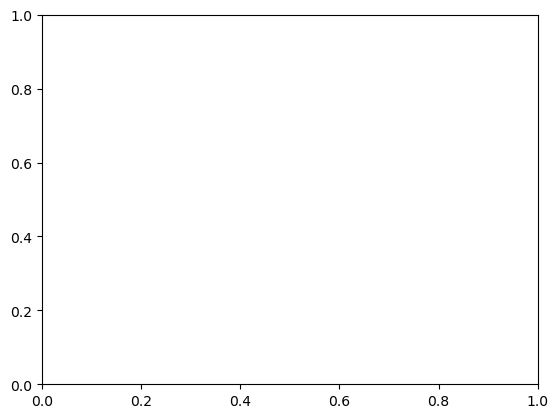

In [6]:
import matplotlib.pyplot as plt

plt.plot(n_runs+1, devaccs)
plt.plot(n_runs+1, testaccs)
plt.show